# Hòa phát group (80-20)

## Xử lý dữ liệu

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('HPG Historical Data.csv', sep=",")
df1 = df.reset_index()['Price']

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset (convert an array of values into a dataset matrix)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

## Model

In [5]:
# Định nghĩa RandomForest model
def create_RandomForest_model():
    model = RandomForestRegressor()
    return model

#Create and train multiple Random Forest models
n_estimators = 5
predictions = []

for _ in range(n_estimators):
    base_model = create_RandomForest_model()
    bagging_model = BaggingRegressor(base_model, n_estimators=50, random_state=42)
    bagging_model.fit(X_train, y_train)
    y_pred = bagging_model.predict(X_test)
    predictions.append(y_pred.flatten())

# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

## Visualize

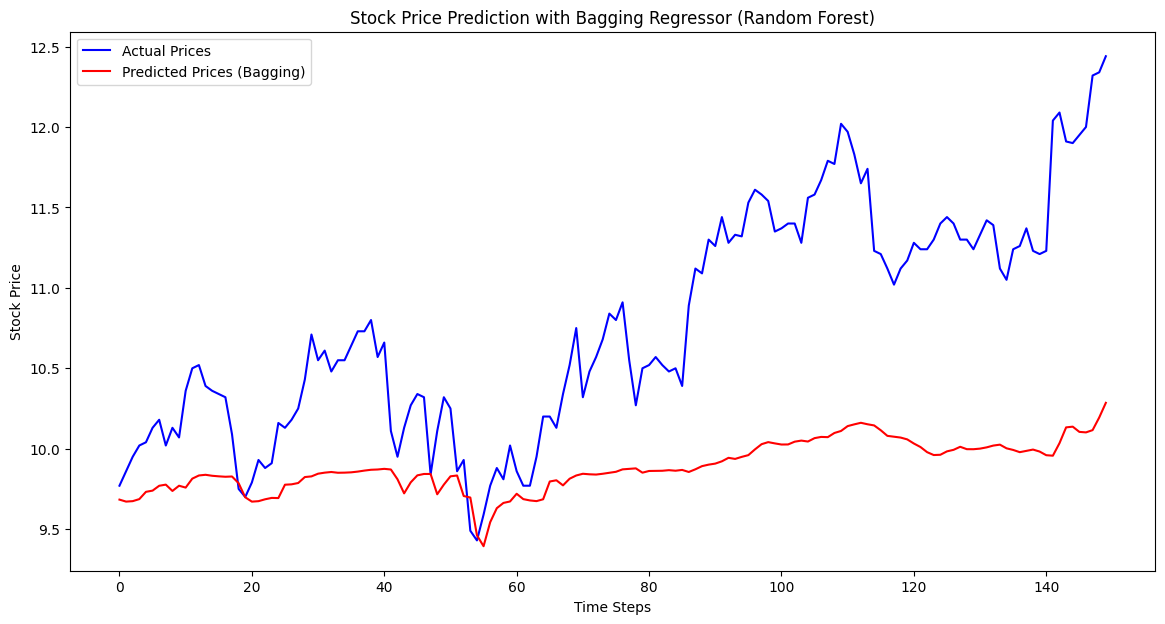

In [6]:
# 9. Trực quan hóa kết quả
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices (Bagging)', color='red')
plt.title('Stock Price Prediction with Bagging Regressor (Random Forest)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# 8. Dự đoán và đánh giá mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Inverse transform the true values for the testing data
true_values_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE for testing data
test_mae = np.mean(abs(bagging_predictions_inv - true_values_testing))
print('Testing MAE:', test_mae)

# Calculate RMSE for testing data
rmse_testing = np.sqrt(mean_squared_error(true_values_testing, bagging_predictions_inv))
print(f'Testing RMSE: {rmse_testing}')

# Calculate MAPE for testing data
mape_testing = mean_absolute_percentage_error(true_values_testing, bagging_predictions_inv) * 100
print(f'Testing MAPE: {mape_testing}')

# Calculate MLSE for testing data
mlse_testing = np.mean((np.log1p(true_values_testing) - np.log1p(bagging_predictions_inv))**2)
print(f'Testing MLSE: {mlse_testing}')

# Calculate R-squared (R²) for testing data
r2_testing = r2_score(true_values_testing, bagging_predictions_inv)
print(f'Testing R²: {r2_testing}')

# Calculate Mean Squared Error (MSE) for testing data
mse_testing = mean_squared_error(true_values_testing, bagging_predictions_inv)
print(f'Testing MSE: {mse_testing}')

Testing MAE: 0.8848077866666673
Testing RMSE: 1.0459258679210244
Testing MAPE: 7.9210161533360885
Testing MLSE: 0.007981655027151152
Testing R²: -1.230926146464217
Testing MSE: 1.0939609211863481
